In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [2]:
tf.config.list_physical_devices('GPU')
physical_devices = tf.config.list_physical_devices('GPU')
# use only 1 GPU
tf.config.set_visible_devices(physical_devices[0], 'GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [3]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()  # close the video file

    mean = tf.math.reduce_mean(frames)  # compute the mean
    std = tf.math.reduce_std(tf.cast(frames, tf.float32)) # compute the standard deviation
    return tf.cast((frames - mean), tf.float32) / std # normalize to zero mean and unit variance


In [4]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [5]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


2023-12-06 15:35:29.708502: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-06 15:35:29.708530: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-06 15:35:29.708535: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-06 15:35:29.708576: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-06 15:35:29.708591: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [115]:
char_to_num.get_vocabulary()
char_to_num(['n','i','c','k'])
num_to_char([14,  9,  3, 11])


<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [6]:
def load_alignments(path:str) ->  List[str]:
    with open(path, 'r') as f:
        alignments = f.readlines()
    tokens =[]
    for line in alignments:
        line = line.split()
        if line[2] !='sil':
            tokens=[*tokens,' ', line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]


In [7]:
def load_data(path:str):
    path = path.numpy().decode('utf-8')
    file_name = path.split('/')[-1].split('.')[0]
    video_path=os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path=os.path.join('data','alignments','s1',f'{file_name}.align')
    frames=load_video(video_path)
    alignments=load_alignments(alignment_path)
    return frames, alignments

In [118]:
# test a single video
test_path='data/s1/bbifzp.mpg'

frames, alignments = load_data(test_path)




AttributeError: 'str' object has no attribute 'numpy'

In [119]:
plt.imshow(frames[40])


IndexError: index 40 is out of bounds for axis 0 with size 2

In [120]:
alignments

array([[16, 12,  1,  3,  5, 39,  2, 12, 21,  5, 39,  9, 14, 39,  9, 39,
        26,  5, 18, 15, 39, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [16, 12,  1,  3,  5, 39, 23,  8,  9, 20,  5, 39,  1, 20, 39, 17,
        39, 15, 14,  5, 39, 19, 15, 15, 14,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [121]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [8]:
def mappable_function(path:str) ->List[str]:  # mappable_function is a function that takes a path and returns a tuple of (frames, alignments)
    return tf.py_function(load_data, [path], [tf.float32, tf.int64])


In [9]:
from matplotlib import pyplot as plt

# import glob
#
# files = glob.glob('./data/s1/*.mpg')

data = tf.data.Dataset.list_files('./data/s1/*.mpg')

data = data.shuffle(500, reshuffle_each_iteration=False)
#
data = data.map(mappable_function)
#
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
# #
data = data.prefetch(tf.data.AUTOTUNE)
# #
# Added for split
train = data.take(450)
#
test = data.skip(450)



In [124]:
frames,alignments=data.as_numpy_iterator().next()


In [125]:
frames

array([[[[[1.4231664 ],
          [1.5000943 ],
          [1.4616303 ],
          ...,
          [0.30771166],
          [0.2692477 ],
          [0.2692477 ]],

         [[1.5000943 ],
          [1.5385582 ],
          [1.4616303 ],
          ...,
          [0.30771166],
          [0.2692477 ],
          [0.2692477 ]],

         [[1.5000943 ],
          [1.5000943 ],
          [1.4616303 ],
          ...,
          [0.3461756 ],
          [0.30771166],
          [0.30771166]],

         ...,

         [[1.0769908 ],
          [1.0385268 ],
          [1.0385268 ],
          ...,
          [0.03846396],
          [0.03846396],
          [0.03846396]],

         [[1.0385268 ],
          [1.0385268 ],
          [1.0385268 ],
          ...,
          [0.03846396],
          [0.03846396],
          [0.03846396]],

         [[1.0385268 ],
          [1.0385268 ],
          [1.0385268 ],
          ...,
          [0.03846396],
          [0.03846396],
          [0.        ]]],


        [[[1.6154

In [126]:
len(frames)

2

In [14]:
sample = data.as_numpy_iterator()


In [15]:
val = sample.next()
val[0]

array([[[[[ 1.4295566 ],
          [ 1.270717  ],
          [ 0.7544882 ],
          ...,
          [ 0.31767926],
          [ 0.23825945],
          [ 0.23825945]],

         [[ 1.2310071 ],
          [ 1.0721675 ],
          [ 0.5559387 ],
          ...,
          [ 0.31767926],
          [ 0.23825945],
          [ 0.23825945]],

         [[ 1.4295566 ],
          [ 1.4295566 ],
          [ 1.310427  ],
          ...,
          [ 0.31767926],
          [ 0.23825945],
          [ 0.23825945]],

         ...,

         [[ 1.1515874 ],
          [ 1.1515874 ],
          [ 1.1515874 ],
          ...,
          [10.126026  ],
          [10.086316  ],
          [10.086316  ]],

         [[ 1.1515874 ],
          [ 1.1515874 ],
          [ 1.1118774 ],
          ...,
          [10.126026  ],
          [10.086316  ],
          [10.086316  ]],

         [[ 1.1515874 ],
          [ 1.1515874 ],
          [ 1.1118774 ],
          ...,
          [10.126026  ],
          [10.086316  ],
          

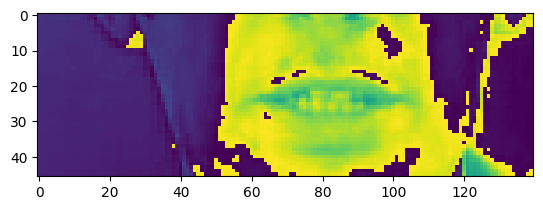

In [132]:
plt.imshow(val[0][0][30])




In [133]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])


<tf.Tensor: shape=(), dtype=string, numpy=b'bin white by t six now'>

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [11]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [12]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [137]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [ ]:
5*17*75

In [16]:
yhat = model.predict(val[0])


2023-12-06 15:37:04.608970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step


In [17]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])


<tf.Tensor: shape=(), dtype=string, numpy=b'eeeeeeeeeeeeeeeeeeeeeeeeeeee7vvvvvvvvvvveeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee'>

In [18]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])


<tf.Tensor: shape=(), dtype=string, numpy=b'eeeeeeeeeeeeeeeeeeeeeeeeeeee7vvvvvvvvvvveeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee'>

In [19]:
model.input_shape


(None, 75, 46, 140, 1)

In [20]:
model.output_shape


(None, 75, 41)

In [21]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [22]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [23]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [24]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)


In [25]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)


In [26]:
schedule_callback = LearningRateScheduler(scheduler)


In [27]:
example_callback = ProduceExample(test)


In [31]:
tf.config.list_physical_devices()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# set GPU
tf.config.set_visible_devices(physical_devices[0], 'GPU')

Num GPUs Available:  1


In [32]:
# run the model with GPU in macos
with tf.device('/GPU:0'):
    model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])


Epoch 1/100
 47/450 [==>...........................] - ETA: 1:49:22 - loss: 101.4370

KeyboardInterrupt: 

Make a prediction

In [151]:
import gdown

url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=30b1366d-51d7-449e-95bc-b3369b4feb00
To: /Users/zhenyili/research project/src/lipNet/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:29<00:00, 3.16MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [ ]:
model.load_weights('models/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]